In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

重新训练模型
Epoch 1/500
66/66 [==============================] - 1s 7ms/step - loss: 24.9842 - accuracy: 0.1001 - val_loss: 10.3356 - val_accuracy: 0.1676
Epoch 2/500
66/66 [==============================] - 0s 3ms/step - loss: 8.4160 - accuracy: 0.1857 - val_loss: 8.7041 - val_accuracy: 0.1989
Epoch 3/500
66/66 [==============================] - 0s 3ms/step - loss: 6.6180 - accuracy: 0.2117 - val_loss: 10.2703 - val_accuracy: 0.1172
Epoch 4/500
66/66 [==============================] - 0s 3ms/step - loss: 6.3626 - accuracy: 0.1985 - val_loss: 5.2112 - val_accuracy: 0.2017
Epoch 5/500
66/66 [==============================] - 0s 3ms/step - loss: 5.2022 - accuracy: 0.2497 - val_loss: 4.9472 - val_accuracy: 0.2887
Epoch 6/500
66/66 [==============================] - 0s 3ms/step - loss: 4.1840 - accuracy: 0.2780 - val_loss: 4.1952 - val_accuracy: 0.3310
Epoch 7/500
66/66 [==============================] - 0s 2ms/step - loss: 3.5543 - accuracy: 0.3074 - val_loss: 2.9251 - val_accuracy: 0.3427
Epo

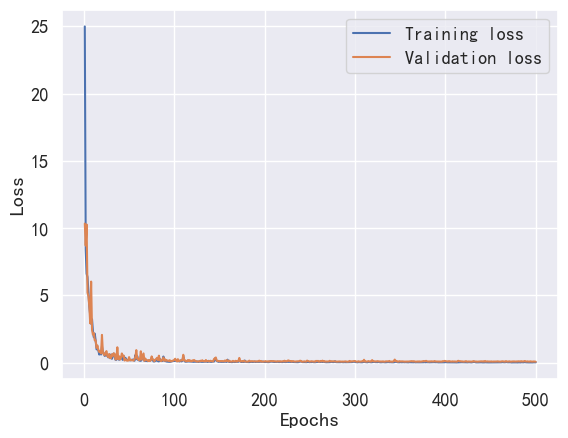

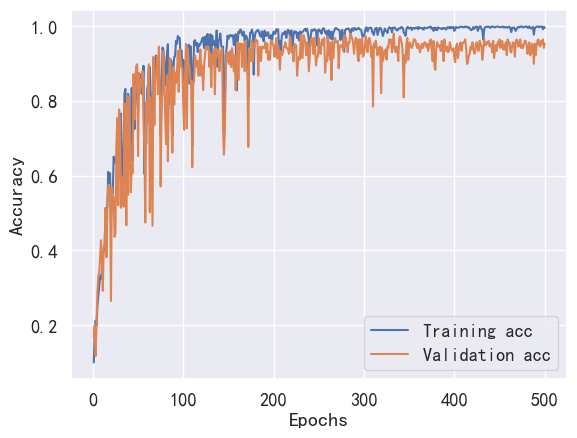

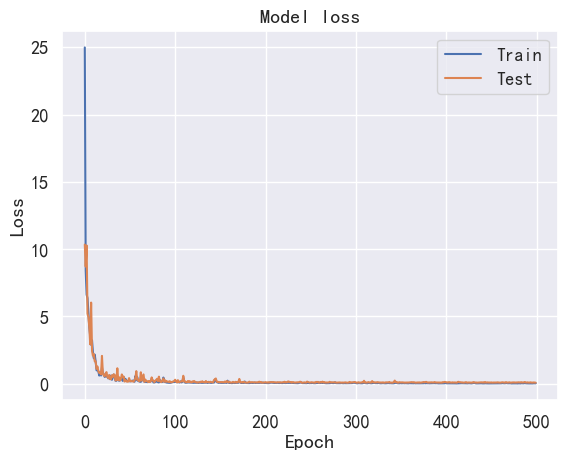

74/74 [==============================] - 0s 999us/step


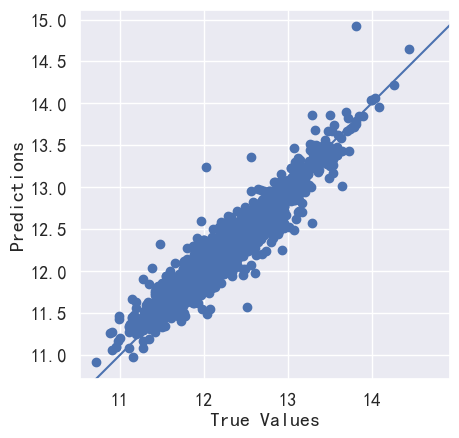

r2_score: 0.9111754427868273
mse: 0.023619011097776164
mae: 0.11106050336438981
mape: 0.009124371853451439


In [11]:
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import *
import os

forceRetrain = True

modelPath = './model1.h5'

df = pd.read_excel('版本1_生成自然对数(Ln)变量_版本1_缺失值处理_Monohulled Sailboats_副本1.xlsx')
# df = pd.read_excel(r'原始数据_2023_MCM_Problem_Y_Boats.xlsx')
df = df.dropna().sample(frac=1).reset_index(drop=True)
X = df
Y = df.pop('Q1-自然对数(Ln)_Listing Price (USD)_缺失值处理')  # 用实际的列名替换“列名”
Y = np.asarray(Y)

# 使用PCA进行降维
pca = PCA(n_components=10)
X = pca.fit_transform(X)

model = None
shouldTrain = False
if not os.path.exists(modelPath) or forceRetrain:
    shouldTrain = True

if not shouldTrain:
    print('加载模型')
    # 加载模型
    model = tf.keras.models.load_model(modelPath)
else:
    print('重新训练模型')

    # 定义模型
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(256 * 2, activation='relu'),
        tf.keras.layers.Dense(1)
    ])


    # 定义自定义指标函数
    def accuracy(y_true, y_pred):
        threshold = 0.6  # 指定阈值
        diff = tf.abs(y_true - y_pred)  # 计算预测值和真实值之差的绝对值
        return tf.reduce_mean(tf.cast(diff <= threshold, tf.float32))  # 统计正确分类的样本数占总样本数的比例


    # 编译模型
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[accuracy])

    # 训练模型
    history = model.fit(X, Y, epochs=500, validation_split=0.1)

    # 绘制学习曲线
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # plt.figure(figsize=(12, 4))
    #
    # plt.subplot(1, 2, 1)
    # plt.plot(epochs, train_loss, 'b-', label='Training loss')
    # plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    # plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    #
    # plt.subplot(1, 2, 2)
    # plt.plot(epochs, train_acc, 'b-', label='Training acc')
    # plt.plot(epochs, val_acc, 'r-', label='Validation acc')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # # plt.savefig('Training and validation loss accuracy.svg')
    # plt.show()

    # 分离loss和accuracy
    sns.lineplot(x=epochs, y=train_loss, label='Training loss')
    sns.lineplot(x=epochs, y=val_loss, label='Validation loss')
    # plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('Training and validation loss.single.svg')
    plt.show()

    sns.lineplot(x=epochs, y=train_acc, label='Training acc')
    sns.lineplot(x=epochs, y=val_acc, label='Validation acc')
    # plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('Training and validation accuracy.single.svg')
    plt.show()

    # 可视化训练和测试误差
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    # plt.ylim([0, 10])
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig('Model loss.svg')
    plt.show()

    # 保存模型
    model.save(modelPath)

# 预测并可视化结果
y_pred = model.predict(X)
plt.scatter(Y, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
# plt.xlim([9e4, 1e5])
# plt.ylim([9e4, 1e5])
_ = plt.plot([-1e10, 1e10], [-1e10, 1e10])
if shouldTrain:
    plt.savefig('visualize result.svg')
plt.show()

print(f'r2_score: {r2_score(Y, y_pred)}')
print(f'mse: {mean_squared_error(Y, y_pred)}')
print(f'mae: {mean_absolute_error(Y, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(Y, y_pred)}')


Epoch 1/10
469/469 [==============================] - 1s 3ms/step - loss: 0.2857 - accuracy: 0.9180 - val_loss: 0.1412 - val_accuracy: 0.9595
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1203 - accuracy: 0.9650 - val_loss: 0.0949 - val_accuracy: 0.9718
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0838 - accuracy: 0.9755 - val_loss: 0.0718 - val_accuracy: 0.9770
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0635 - accuracy: 0.9808 - val_loss: 0.0666 - val_accuracy: 0.9801
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.0637 - val_accuracy: 0.9794
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0397 - accuracy: 0.9879 - val_loss: 0.0641 - val_accuracy: 0.9800
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0331 - accuracy: 0.9902 - val_loss: 0.0644 - val_accuracy: 0.9799
Epoch 

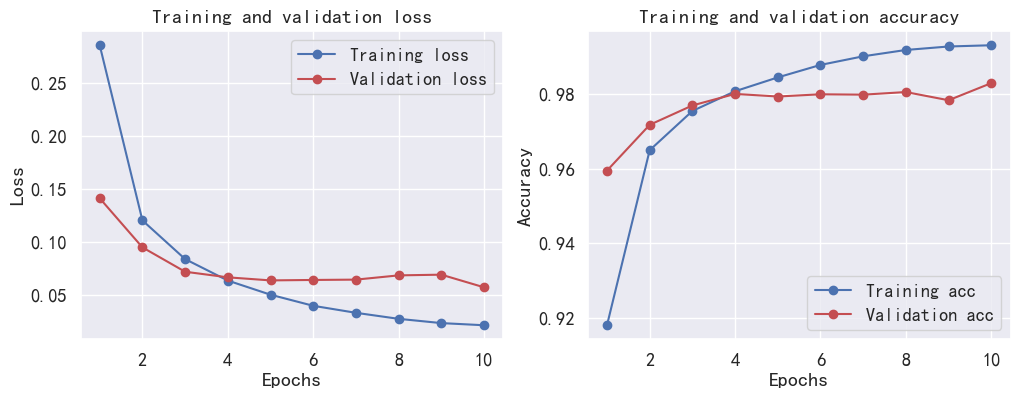

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 加载数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 数据预处理
x_train = x_train.reshape((60000, 28 * 28))
x_test = x_test.reshape((10000, 28 * 28))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 创建模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(28 * 28,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 编译模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 创建回调函数
history = tf.keras.callbacks.History()

# 训练模型
model.fit(x_train, y_train, epochs=10, batch_size=128,
          validation_data=(x_test, y_test), callbacks=[history])

# 绘制学习曲线
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
